In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import seaborn as sns
import math

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
train_data = (pd.read_csv('../data/home-credit-default-risk/application_train.csv'))
rows_to_keep = int(len(train_data) * 0.6)
train_data = train_data.sample(n=rows_to_keep, random_state=42)
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])

y = train_data.pop('TARGET')

train_data.drop(columns=['SK_ID_CURR'], axis=1, inplace=True)
train_data.head()

Number of data points :  184506
Number of features :  122


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
245895,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,418500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
98194,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,1179000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
36463,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,495000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
249923,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,225000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
158389,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,234000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [3]:
categorical_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [4]:
numerical_columns = train_data.select_dtypes(include=['int', 'float']).columns

In [5]:
y.head()

245895    0
98194     0
36463     0
249923    0
158389    0
Name: TARGET, dtype: int64

In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(train_data[categorical_columns])

df_encoded = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
df_encoded.shape

(184506, 146)

In [7]:
from sklearn.preprocessing import StandardScaler

# Perform standard scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(train_data[numerical_columns]), columns=numerical_columns)

df_scaled.shape

(184506, 104)

In [8]:
# df_train_final = pd.concat([df_scaled, df_encoded], axis=1)

df_train_final = df_scaled

In [9]:
# # getting test data

# test_data = (pd.read_csv('./data/home-credit-default-risk/application_test.csv'))
# rows_to_keep = int(len(train_data) * 0.25)
# test_data = test_data.sample(n=rows_to_keep, random_state=42)
# print('Number of data points : ', test_data.shape[0])
# print('Number of features : ', test_data.shape[1])

# test_data.drop(columns=['SK_ID_CURR'], axis=1, inplace=True)


In [10]:
# test_data_encoded = pd.DataFrame(encoder.transform(test_data[categorical_columns]).toarray(), columns=encoder.get_feature_names_out(categorical_columns))
# test_data_encoded.shape

In [11]:
# test_data_scaled = pd.DataFrame(scaler.transform(test_data[numerical_columns]), columns=numerical_columns)
# test_data_scaled.shape

In [12]:
# df_test_final = pd.concat([test_data_scaled, test_data_encoded], axis=1)
# df_test_final.shape

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_train_final, y, test_size=0.2, random_state=42)

print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(184506,)
(147604, 104)
(36902, 104)
(147604,)
(36902,)


In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_filled = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test_filled = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [15]:
X_train_filled.isna().any()

CNT_CHILDREN                  False
AMT_INCOME_TOTAL              False
AMT_CREDIT                    False
AMT_ANNUITY                   False
AMT_GOODS_PRICE               False
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     False
AMT_REQ_CREDIT_BUREAU_WEEK    False
AMT_REQ_CREDIT_BUREAU_MON     False
AMT_REQ_CREDIT_BUREAU_QRT     False
AMT_REQ_CREDIT_BUREAU_YEAR    False
Length: 104, dtype: bool

In [16]:
X_test_filled.isna().any()

CNT_CHILDREN                  False
AMT_INCOME_TOTAL              False
AMT_CREDIT                    False
AMT_ANNUITY                   False
AMT_GOODS_PRICE               False
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     False
AMT_REQ_CREDIT_BUREAU_WEEK    False
AMT_REQ_CREDIT_BUREAU_MON     False
AMT_REQ_CREDIT_BUREAU_QRT     False
AMT_REQ_CREDIT_BUREAU_YEAR    False
Length: 104, dtype: bool

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train_filled, y_train)
y_pred = logreg.predict(X_test_filled)

Accuracy: 0.9167524795404043


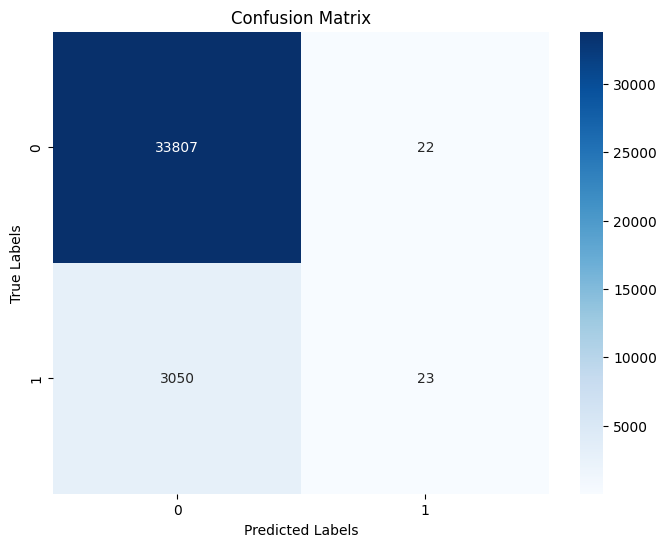

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
# precision = precision_score(y_test, y_pred)
# print("Precision:", precision)

# # Calculate recall
# recall = recall_score(y_test, y_pred)
# print("Recall:", recall)

# # Calculate F1 score
# f1 = f1_score(y_test, y_pred)
# print("F1 score:", f1)

# # Calculate ROC AUC score
# roc_auc = roc_auc_score(y_test, y_pred)
# print("ROC AUC score:", roc_auc)

# # Calculate confusion matrix
# confusion_mat = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(confusion_mat)

# Assuming your true labels are in y_true and predicted labels are in y_pred
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class labels
class_labels = np.unique(np.concatenate((y_test, y_pred)))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
